In [0]:
# Some options
test_str = 'test'       # validation, test 
net_str = 'vgg16'    # vgg16, resnet18
task = '_entire'        # _FC_Only, _entire

train_flag = True   # train the network if True, test the network if False
save_model = True   # Save Model if True

# If testing, turn off the training and don't save the model
if (test_str == 'test'):
    train_flag = False
    save_model = False

PATH = 'drive/My Drive/Assignment 5 Models/' + net_str + task + '.pth'

batch_size = 64          # Default = 8
Epochs = 10
lr = 0.001
momentum = 0.9

In [199]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from collections import OrderedDict

In [0]:
data_dir = 'drive/My Drive/Assignment 5 Dataset/'

In [202]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + 'train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + test_str, transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


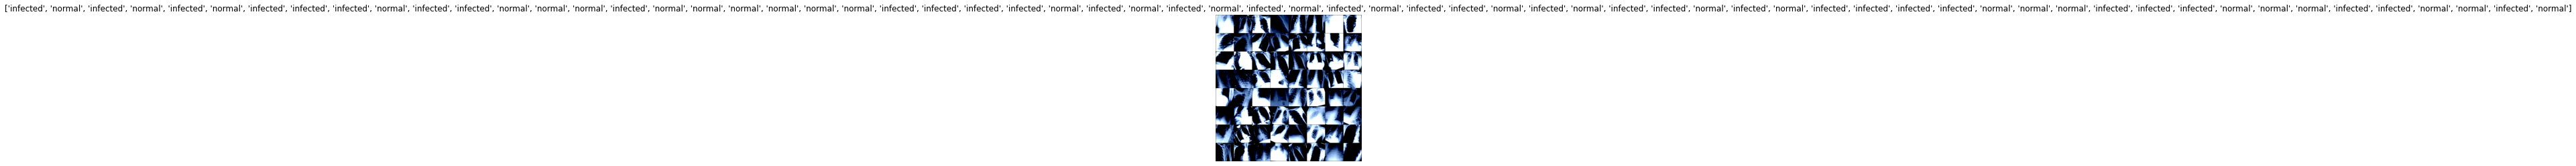

In [203]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [0]:
# Load the pretrained model from pytorch
if (net_str == 'resnet18'):
    net = models.resnet18(pretrained=True)
    # print('Output Layer of %s : ', net_str, net.fc.out_features)
else:
    net = models.vgg16(pretrained=True)
    # print('Output Layer of %s : ', net_str, net.classifier[6].out_features)

# print(net)

### Removing Last Layer

In [0]:
# if (net_str == 'resnet18'):
#     print('resnet18')

# else:
#     num_features = net.classifier[6].in_features
#     features = list(net.classifier.children())[:-1] # Remove last layer


# print(net)

### Freezing and Adding Layers

In [206]:
if (task == '_FC_Only'):    # task 1

    for param in net.parameters():
        param.requires_grad = False

    if (net_str == 'resnet18'):

        fc = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(512,22 * 10 + 100)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(22 * 10 + 100, 2))
        ]))
        
        net.fc = fc

    if (net_str == 'vgg16'):

        num_features = net.classifier[6].in_features
        features = list(net.classifier.children())[:-1]
        features.extend([nn.Linear(num_features, 22 * 10 + 100)])
        net.classifier = nn.Sequential(*features)

        features.extend([nn.ReLU()])
        net.classifier = nn.Sequential(*features)

        features.extend([nn.Linear(22 * 10 + 100, len(class_names))])
        net.classifier = nn.Sequential(*features)

if (task == '_entire'):    # task 2

    if (net_str == 'resnet18'):

        # net.layer3.requires_grad = False
        for param in net.parameters():
            param.requires_grad = False

    if (net_str == 'vgg16'):

        # This freezes layers 2
        ct = 1
        for child in net.children():
            ct += 1
            if ct < 3:
                for param in child.parameters():
                    param.requires_grad = False

print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Loss function, Optimizer and GPU

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr, momentum)

In [208]:
# #if you have gpu then you need to convert the network and data to cuda
# #the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
print(device)

cuda:0


### Training

In [0]:
if (train_flag):

    from tqdm import tqdm

    net.train()

    loss_arr = []

    for epoch in range(Epochs):  # loop over the dataset multiple times

        pbar = tqdm(enumerate(trainloader))
        for i, data in pbar:
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
            # because PyTorch accumulates the gradients on subsequent backward passes. 
            # This is convenient while training RNNs. 
            # So, the default action is to accumulate the gradients on every loss.backward() call

            # forward + backward + optimize
            outputs = net(inputs)               #----> forward pass
            loss = criterion(outputs, labels)   #----> compute loss
            loss.backward()                     #----> backward pass
            optimizer.step()                    #----> weights update        
            
            pbar.set_description(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch + 1, i * len(inputs), len(trainloader.dataset),
                    100. * i / len(trainloader),
                    loss.data))

        loss_arr.append(loss.data)

    print('Finished Training')

    # This code snippet may be helpful in debugging what layers you are training
    # for name, param in model.named_parameters():
    #     if param.requires_grad:
    #         print(name)

    # Plot Loss
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(range(Epochs), loss_arr)

In [0]:
if (save_model):
    torch.save(net.state_dict(), PATH)

### Testing

In [0]:
# Load the saved network from Google Drive if train_flag is not true
if (train_flag == False):
    net.load_state_dict(torch.load(PATH))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


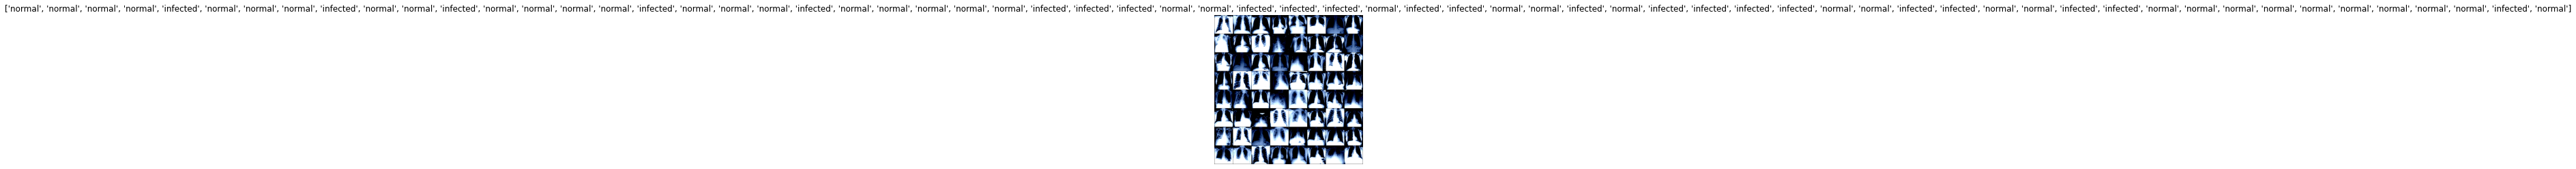

In [212]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [213]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = net(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal normal normal normal normal normal infected normal normal infected infected normal normal normal infected normal normal normal infected normal normal normal normal normal infected infected infected normal normal normal normal infected normal infected infected normal normal infected normal infected infected infected infected normal normal normal infected normal normal infected infected normal normal normal normal normal normal normal normal normal infected normal
Ground Truth:  normal normal normal normal infected normal normal normal infected normal normal infected normal normal normal normal infected normal normal normal infected normal normal normal normal normal infected infected infected normal normal infected infected infected normal infected infected normal normal infected normal infected infected infected infected normal normal infected infected normal normal infected infected normal normal normal normal normal normal normal normal normal infecte

In [214]:
# Confusion Matrix

nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)

        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print('Confusion Matrix : ', confusion_matrix)      # Confusion Matrix = [TP, FP
                                                    #                     FN, TN] for 2 class-classification

per_class_acc = 100 * confusion_matrix.diag()/confusion_matrix.sum(1)
for i in range(len(per_class_acc)):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], per_class_acc[i]))
    
print('Overall Accuracy : %2d %%' % (sum(per_class_acc)/len(per_class_acc)))

Confusion Matrix :  tensor([[537.,  78.],
        [ 19., 866.]])
Accuracy of infected : 87 %
Accuracy of normal : 97 %
Overall Accuracy : 92 %


In [215]:
# F Score
TP = confusion_matrix[0][0]
FP = confusion_matrix[0][1]
FN = confusion_matrix[1][0]
TN = confusion_matrix[1][1]

precision = TP / (TP + FP)      # precision = TP / (TP + FP)
recall = TP / (TP + FN)         # recall = TP / (TP + FN)

F_score = 2*((precision*recall)/(precision+recall))

print('F_score : ')
print(F_score)

F_score : 
tensor(0.9172)
